# Final Project: Sporting Game Outcome Prediction
## Data Loading and Processing

This initial section focuses on setting up the environment and defining functions to load and transform the raw play-by-play data into a usable format for game outcome prediction. We will:

* **Import Libraries:** Bring in essential libraries like pandas for data manipulation, numpy for numerical operations, matplotlib/seaborn for visualization, and various modules from scikit-learn for modeling and evaluation.
* **Define `load_and_process_data` Function:** Create a function to handle a single CSV file. This function will:
    * Read the play-by-play data.
    * Identify unique teams and attempt robust home/away team assignment (checking for `IsHome` or similar columns, falling back to approximation if needed).
    * Iterate through each game, accumulating team statistics (yards, attempts, turnovers, penalties, scores, etc.) by processing individual plays.
    * Calculate game-level differential features (e.g., `yards_diff`, `turnovers_diff`, `ypa_diff`) which often provide strong predictive signals.
    * Determine the game winner based on simplified score calculation (to be used as the target variable).
    * Return a pandas DataFrame where each row represents a single game with its aggregated stats and differentials.
* **Define `combine_data_multiple_years` Function:** Create a helper function to apply `load_and_process_data` to multiple yearly CSV files and concatenate the results into a single DataFrame.
* **Handle Warnings:** Suppress convergence and user warnings for cleaner output during potentially long computations like grid search.

In [101]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, RobustScaler # Include both scalers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance # For non-linear feature importance
import time
import warnings

# Ignore convergence warnings for cleaner output during grid search
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Ignore potential user warnings from libraries

# Function to load and process a single year of data
def load_and_process_data(filepath):
    """
    Load and process a single year of play-by-play data.
    Aggregates statistics to the game level and calculates differentials.
    Returns a DataFrame with game-level aggregated statistics.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, low_memory=False) # low_memory=False can help with mixed types
        print(f" Data shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame() # Return empty DataFrame if file not found

    # Check for necessary columns early
    required_cols = ['GameId', 'OffenseTeam', 'DefenseTeam', 'Yards', 'IsRush', 'IsPass', 
                     'IsSack', 'IsInterception', 'IsFumble', 'IsPenalty', 'PenaltyTeam', 
                     'PenaltyYards', 'IsTouchdown', 'PlayType', 'Description', 'Down', 'SeriesFirstDown']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Missing required columns in {filepath}")
        missing = [col for col in required_cols if col not in df.columns]
        print(f"Missing columns: {missing}")
        return pd.DataFrame()
        
    # --- Home/Away Team Identification --- 
    # Attempt to identify home team more robustly if possible
    # Check common column names indicating home status
    home_col = None
    if 'IsHome' in df.columns:
        home_col = 'IsHome'
    elif 'HomeTeam' in df.columns: # If there's a dedicated HomeTeam column per game
        home_col = 'HomeTeam_Identifier' # Placeholder, logic needs adjustment based on actual structure
        # Example: df['HomeTeam_Identifier'] = (df['OffenseTeam'] == df['HomeTeam']) # Needs actual HomeTeam column
    elif 'GameLocation' in df.columns: # If location indicates home/away
        home_col = 'IsHome_Location' # Placeholder
        # Example: df['IsHome_Location'] = (df['GameLocation'] == 'Home') # Needs actual GameLocation column
    
    # Group by game to create game-level features
    game_stats = {}

    # Iterate through each unique game
    for game_id in df['GameId'].unique():
        game_df = df[df['GameId'] == game_id].copy() # Use .copy() to avoid SettingWithCopyWarning

        # Get unique teams involved in the game
        teams = set(game_df['OffenseTeam'].dropna().unique()) | set(game_df['DefenseTeam'].dropna().unique())
        teams = [team for team in teams if isinstance(team, str) and team.strip()]

        # Skip if we don't have exactly 2 teams identified
        if len(teams) != 2:
            # print(f"Skipping GameId {game_id}: Found {len(teams)} teams ({teams})")
            continue
            
        team1, team2 = teams[0], teams[1]
        home_team, away_team = None, None

        # Determine Home/Away based on identified column or approximation
        if home_col == 'IsHome':
            # Find the first play where IsHome is defined for team1 or team2
            home_play = game_df[((game_df['OffenseTeam'] == team1) | (game_df['DefenseTeam'] == team1)) & game_df['IsHome'].notna()].iloc[0] if not game_df[((game_df['OffenseTeam'] == team1) | (game_df['DefenseTeam'] == team1)) & game_df['IsHome'].notna()].empty else None
            if home_play is not None:
                if home_play['IsHome'] == 1:
                    home_team, away_team = team1, team2
                else:
                    home_team, away_team = team2, team1
        # Add logic here if using 'HomeTeam_Identifier' or 'IsHome_Location' based on actual data structure
        
        # If robust identification failed, use approximation
        if home_team is None or away_team is None:
            # print(f"Warning: Using approximation for home/away in GameId {game_id}")
            home_team, away_team = team1, team2 # Approximation

        # Initialize team stats dictionaries (add new stats)
        home_stats = {
            'total_yards': 0, 'pass_yards': 0, 'rush_yards': 0,
            'pass_attempts': 0, 'rush_attempts': 0, 'turnovers': 0,
            'sacks_taken': 0, 'penalties': 0, 'penalty_yards': 0,
            'touchdowns': 0, 'field_goals': 0,
            'third_down_attempts': 0, 'third_down_conversions': 0, # New
            'fg_attempts': 0, 'punt_yards': 0 # New
        }
        away_stats = home_stats.copy()

        # Calculate stats for each team by iterating through plays
        for _, play in game_df.iterrows():
            off_team = play['OffenseTeam']
            if not isinstance(off_team, str) or not off_team.strip():
                continue # Skip plays with missing offense team

            # Determine which team's stats to update
            is_home_offense = (off_team == home_team)
            current_team_stats = home_stats if is_home_offense else away_stats
            # opp_team_stats = away_stats if is_home_offense else home_stats # Needed if calculating defensive stats explicitly

            # --- Accumulate Stats --- 
            # Yards (handle potential NaN)
            yards = play.get('Yards', 0)
            if pd.notna(yards):
                current_team_stats['total_yards'] += yards
                if play.get('IsRush', 0) == 1:
                    current_team_stats['rush_yards'] += yards
                    current_team_stats['rush_attempts'] += 1
                elif play.get('IsPass', 0) == 1:
                    current_team_stats['pass_yards'] += yards
                    current_team_stats['pass_attempts'] += 1
            
            # Sacks (recorded against the offense)
            if play.get('IsSack', 0) == 1:
                current_team_stats['sacks_taken'] += 1
                # Ensure pass attempt is counted even on sacks if not already marked as IsPass=1
                if play.get('IsPass', 0) != 1:
                     current_team_stats['pass_attempts'] += 1
            
            # Turnovers
            if play.get('IsInterception', 0) == 1 or play.get('IsFumble', 0) == 1:
                current_team_stats['turnovers'] += 1
                
            # Penalties (only count if against the current offense team)
            if play.get('IsPenalty', 0) == 1 and pd.notna(play.get('PenaltyTeam')) and play['PenaltyTeam'] == off_team:
                current_team_stats['penalties'] += 1
                # Assuming PenaltyYards are only counted if penalty is accepted (often implied by IsPenalty=1)
                penalty_yards = play.get('PenaltyYards', 0)
                if pd.notna(penalty_yards):
                     current_team_stats['penalty_yards'] += penalty_yards
            
            # Scoring Plays (ensure it's the offense scoring)
            if play.get('IsTouchdown', 0) == 1 and off_team == play.get('OffenseTeam'): 
                current_team_stats['touchdowns'] += 1
            if play.get('PlayType') == 'FIELD GOAL':
                current_team_stats['fg_attempts'] += 1 # Count attempt
                # Check description for success (might need refinement based on data variations)
                if 'IS GOOD' in str(play.get('Description', '')).upper():
                    current_team_stats['field_goals'] += 1 # Count make
            
            # Third Downs
            if play.get('Down') == 3:
                current_team_stats['third_down_attempts'] += 1
                if play.get('SeriesFirstDown', 0) == 1:
                    current_team_stats['third_down_conversions'] += 1
            
            # Punt Yards (assuming 'Yards' on PUNT is net yardage - needs validation)
            if play.get('PlayType') == 'PUNT':
                 punt_yards = play.get('Yards', 0)
                 if pd.notna(punt_yards):
                    current_team_stats['punt_yards'] += punt_yards
        
        # --- Calculate Game Outcome & Differentials ---
        # Estimate final score (simplified - ignores PATs, 2pt conversions, safeties)
        home_score = home_stats['touchdowns'] * 7 + home_stats['field_goals'] * 3 
        away_score = away_stats['touchdowns'] * 7 + away_stats['field_goals'] * 3 

        # Determine winner (target variable: 1 if home team wins, 0 otherwise)
        # Handle ties: Assign tie as loss for home team (0) or could be excluded/handled differently
        winner = 1 if home_score > away_score else 0 
        
        # Small constant to prevent division by zero
        epsilon = 1e-6 

        # Calculate efficiency differentials
        home_ypa = home_stats['pass_yards'] / (home_stats['pass_attempts'] + epsilon)
        away_ypa = away_stats['pass_yards'] / (away_stats['pass_attempts'] + epsilon)
        ypa_diff = home_ypa - away_ypa

        home_yra = home_stats['rush_yards'] / (home_stats['rush_attempts'] + epsilon)
        away_yra = away_stats['rush_yards'] / (away_stats['rush_attempts'] + epsilon)
        yra_diff = home_yra - away_yra

        home_3rd_conv_pct = home_stats['third_down_conversions'] / (home_stats['third_down_attempts'] + epsilon)
        away_3rd_conv_pct = away_stats['third_down_conversions'] / (away_stats['third_down_attempts'] + epsilon)
        third_down_conv_pct_diff = home_3rd_conv_pct - away_3rd_conv_pct
        
        # Calculate derived differentials
        total_attempts_diff = (home_stats['pass_attempts'] + home_stats['rush_attempts']) - \
                              (away_stats['pass_attempts'] + away_stats['rush_attempts'])
        yards_per_play_diff = (home_stats['total_yards'] - away_stats['total_yards']) / (total_attempts_diff + epsilon)
        
        # Note: Adding 1 to denominator avoids division by zero if pass_attempts_diff is 0
        rush_pass_ratio_diff = (home_stats['rush_attempts'] / (home_stats['pass_attempts'] + epsilon)) - \
                               (away_stats['rush_attempts'] / (away_stats['pass_attempts'] + epsilon))

        # Create dictionary of differential features for the game
        # Positive difference generally means home team advantage (check turnovers, sacks, penalties)
        feature_dict = {
            'yards_diff': home_stats['total_yards'] - away_stats['total_yards'],
            'pass_yards_diff': home_stats['pass_yards'] - away_stats['pass_yards'],
            'rush_yards_diff': home_stats['rush_yards'] - away_stats['rush_yards'],
            'turnovers_diff': away_stats['turnovers'] - home_stats['turnovers'], # Fewer TO is better
            'sacks_diff': away_stats['sacks_taken'] - home_stats['sacks_taken'], # Fewer sacks taken is better
            'penalties_diff': away_stats['penalties'] - home_stats['penalties'], # Fewer penalties is better
            'penalty_yards_diff': away_stats['penalty_yards'] - home_stats['penalty_yards'], # Fewer penalty yards is better
            'pass_attempts_diff': home_stats['pass_attempts'] - away_stats['pass_attempts'],
            'rush_attempts_diff': home_stats['rush_attempts'] - away_stats['rush_attempts'],
            # Derived & Efficiency Features
            'yards_per_play_diff': yards_per_play_diff,
            'rush_pass_ratio_diff': rush_pass_ratio_diff,
            'ypa_diff': ypa_diff, # Yards per pass attempt diff
            'yra_diff': yra_diff, # Yards per rush attempt diff
            'third_down_conv_pct_diff': third_down_conv_pct_diff,
            # Other/Special Teams Features
            'fg_attempts_diff': home_stats['fg_attempts'] - away_stats['fg_attempts'],
            'punt_yards_diff': home_stats['punt_yards'] - away_stats['punt_yards'], # Lower net punt yards might be better (field position)
            # --- Leaky Features (for reference, will be dropped before training) ---
            'touchdowns_diff': home_stats['touchdowns'] - away_stats['touchdowns'], 
            'field_goals_diff': home_stats['field_goals'] - away_stats['field_goals'], 
            'home_score': home_score,
            'away_score': away_score,
            # --- Target Variable ---
            'winner': winner 
        }

        game_stats[game_id] = feature_dict

    # Convert dictionary to DataFrame
    games_df = pd.DataFrame.from_dict(game_stats, orient='index')
    games_df.reset_index(inplace=True)
    games_df.rename(columns={'index': 'GameId'}, inplace=True)

    print(f" Extracted {len(games_df)} games from {filepath}.")
    return games_df

# Function to combine multiple years of data
def combine_data_multiple_years(filepaths):
    """
    Load and combine processed game data from multiple CSV files.
    """
    all_games_data = []
    for filepath in filepaths:
        year_data = load_and_process_data(filepath)
        if not year_data.empty:
            all_games_data.append(year_data)
        else:
            print(f"Skipping empty DataFrame from {filepath}")

    # Combine all years if data was loaded
    if not all_games_data:
        print("No data loaded, returning empty DataFrame.")
        return pd.DataFrame()
        
    combined_data = pd.concat(all_games_data, ignore_index=True)
    print(f"\nCombined data shape: {combined_data.shape}")
    return combined_data


## Feature Engineering and Selection

This cell executes the data loading and initial feature preparation steps. It involves:

* **Specifying Data Files:** Defining the list of CSV files containing the play-by-play data (currently set to use only `pbp-2024.csv`).
* **Loading Data:** Calling the previously defined functions (`load_and_process_data` or `combine_data_multiple_years`) to get the game-level DataFrame `games_df`.
* **Handling Missing/Infinite Values:** Replacing any `inf` values generated during calculations with `NaN` and then filling all `NaN` values with 0. This ensures the data is clean for modeling. (Note: Filling with 0 is a simple strategy; more sophisticated imputation could be considered if needed).
* **Defining Feature Sets:** Identifying columns that are identifiers (`GameId`), potentially leaky (`touchdowns_diff`, scores, etc.), or the target variable (`winner`).
* **Separating X and y:** Creating the feature matrix `X` by selecting all columns except the ones identified to be dropped, and creating the target vector `y` containing the `winner` column.
* **Verification:** Printing the final list of features, the number of features, the class balance of the target variable, and checking for any remaining `inf` or `NaN` values in `X`.

In [102]:
# Define filepaths (Adjust as needed - using only 2024 for this example)
data_filepaths = [
    'pbp-2024.csv' 
    'pbp-2020.csv',
    'pbp-2021.csv',
    'pbp-2022.csv',
    'pbp-2023.csv'
]

# Load and combine data
# If using only one file, can call load_and_process_data directly
if len(data_filepaths) == 1:
    games_df = load_and_process_data(data_filepaths[0])
else:
    games_df = combine_data_multiple_years(data_filepaths)

# --- Handle Potential Infinities and NaNs --- 
# Replace infinities that might arise from division by zero (or near zero) during feature engineering
games_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs. Using 0 might be acceptable for differentials, 
# but consider median/mean imputation if appropriate for specific features.
# Check which columns have NaNs before filling
if games_df.isnull().any().any():
    print("\nColumns with NaNs before filling:")
    print(games_df.isnull().sum()[games_df.isnull().sum() > 0])
    games_df.fillna(0, inplace=True) # Simple fill with 0 for now
else:
    print("\nNo NaNs found in the aggregated DataFrame.")

# --- Separate Features (X) and Target (y) ---
# Define leaky features (directly related to the outcome or score)
leaky_features = ['touchdowns_diff', 'field_goals_diff', 'home_score', 'away_score']
# Define identifier columns to drop
identifier_cols = ['GameId']
# Columns to drop before training
cols_to_drop = identifier_cols + leaky_features + ['winner'] # Also drop target 'winner'

# Define the final feature columns by taking all columns EXCEPT those to drop
# Ensure 'winner' column exists before proceeding
if 'winner' not in games_df.columns:
    print("Error: 'winner' column not found in DataFrame. Cannot proceed.")
    # Handle error appropriately, maybe raise exception or exit
    X, y = pd.DataFrame(), pd.Series() # Assign empty structures
else:
    final_feature_cols = [col for col in games_df.columns if col not in cols_to_drop]
    X = games_df[final_feature_cols].copy()
    y = games_df['winner'].copy()

    print("\nFeatures used for prediction:")
    print(X.columns.tolist())
    print(f"Number of features: {X.shape[1]}")

    # Check class balance of the target variable
    print("\nClass balance (winner):")
    class_balance = y.value_counts(normalize=True)
    print(class_balance)

    # Final check for infinities/NaNs in features X before splitting
    print(f"\nInfinities remaining in X before split: {np.any(np.isinf(X.values))}")
    print(f"NaNs remaining in X before split: {X.isnull().values.any()}")


Loading data from pbp-2024.csvpbp-2020.csv...
Error: File not found at pbp-2024.csvpbp-2020.csv
Skipping empty DataFrame from pbp-2024.csvpbp-2020.csv
Loading data from pbp-2021.csv...
 Data shape: (42795, 45)
 Extracted 240 games from pbp-2021.csv.
Loading data from pbp-2022.csv...
 Data shape: (38598, 45)
 Extracted 218 games from pbp-2022.csv.
Loading data from pbp-2023.csv...
 Data shape: (51287, 45)
 Extracted 272 games from pbp-2023.csv.

Combined data shape: (730, 22)

No NaNs found in the aggregated DataFrame.

Features used for prediction:
['yards_diff', 'pass_yards_diff', 'rush_yards_diff', 'turnovers_diff', 'sacks_diff', 'penalties_diff', 'penalty_yards_diff', 'pass_attempts_diff', 'rush_attempts_diff', 'yards_per_play_diff', 'rush_pass_ratio_diff', 'ypa_diff', 'yra_diff', 'third_down_conv_pct_diff', 'fg_attempts_diff', 'punt_yards_diff']
Number of features: 16

Class balance (winner):
winner
1    0.531507
0    0.468493
Name: proportion, dtype: float64

Infinities remaining 

## Train-Test Split and Cross-Validation Setup

This cell prepares the data for model training and evaluation by splitting it and defining a cross-validation strategy. The key steps are:

* **Check Data Validity:** Ensure the feature matrix `X` and target vector `y` are not empty before attempting the split.
* **Train-Test Split:** Divide the dataset into training (80%) and testing (20%) sets using `train_test_split`.
    * `stratify=y` is used to ensure that the proportion of winner classes (0 and 1) is approximately the same in both the training and testing sets. This is important for reliable evaluation, especially if the classes are not perfectly balanced.
    * `random_state=42` ensures that the split is the same every time the code is run, making the results reproducible.
* **Cross-Validation Strategy:** Define the cross-validation method using `StratifiedKFold`.
    * `n_splits=5` means the training data will be split into 5 folds for cross-validation during hyperparameter tuning (Grid Search).
    * `shuffle=True` randomizes the data before splitting into folds.
    * `random_state=42` ensures reproducibility of the folds.

In [103]:
# Ensure X and y are not empty before splitting
if X.empty or y.empty:
    print("\nError: Feature matrix X or target vector y is empty. Cannot perform train-test split.")
else:
    # Split data into training and testing sets (e.g., 80% train, 20% test)
    # Use stratify=y to maintain class proportions in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,      # Hold out 20% for testing
        random_state=42,    # For reproducibility
        stratify=y          # Important for classification, especially if classes are imbalanced
    )
    
    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    # Set up cross-validation strategy
    # Stratified K-Fold is good for classification to preserve class percentage in each fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Using Stratified K-Fold with {cv.get_n_splits()} splits.")


Training set shape: (584, 16)
Testing set shape: (146, 16)
Using Stratified K-Fold with 5 splits.


## SVM Pipeline and Expanded Parameter Grid Setup

This section sets up the Support Vector Machine (SVM) modeling framework using pipelines and defines an expanded parameter grid for hyperparameter tuning. The steps include:

* **Pipeline Creation:** Define two `Pipeline` objects (`pipeline_no_weights`, `pipeline_balanced`).
    * Each pipeline includes a scaler step (initially `StandardScaler`, but will be replaced by GridSearchCV) and an `SVC` (Support Vector Classifier) step.
    * `probability=True` is set to enable probability estimates needed for ROC AUC calculation.
    * `random_state=42` ensures reproducibility.
    * One pipeline uses `class_weight=None` (default), and the other uses `class_weight='balanced'` to address potential class imbalance.
    * `max_iter=10000` is added as a safeguard against potential convergence issues with certain parameter combinations.
* **Expanded Parameter Grid (`param_grid`):** Define a list of dictionaries specifying the hyperparameters to search over.
    * Tests both `StandardScaler` and `RobustScaler` for the 'scaler' step.
    * Tests both `'linear'` and `'rbf'` kernels for the 'svm__kernel' step.
    * Defines ranges for `'svm__C'` (regularization parameter) using `np.logspace` for both kernels.
    * Defines ranges for `'svm__gamma'` (kernel coefficient for RBF) using `np.logspace`.
* **Test Grid (Commented Out):** Includes a much smaller grid (`param_grid_test`) useful for quick debugging or testing the workflow.
* **Grid Calculation:** Calculates and prints the total number of parameter combinations and model fits that will be performed during the grid search.

In [104]:
# Create pipelines for SVM. 
# The 'scaler' step is a placeholder that GridSearchCV will fill.
# We will compare performance with and without class weighting.

pipeline_no_weights = Pipeline([
    ('scaler', StandardScaler()), # Default scaler, will be replaced by grid search
    # Added max_iter to prevent potential infinite loops on non-converging fits
    ('svm', SVC(probability=True, random_state=42, class_weight=None, max_iter=10000)) 
])

pipeline_balanced = Pipeline([
    ('scaler', StandardScaler()), # Default scaler, will be replaced by grid search
    # Added max_iter to prevent potential infinite loops on non-converging fits
    ('svm', SVC(probability=True, random_state=42, class_weight='balanced', max_iter=10000)) 
])

# --- Expanded Parameter Grid --- 
# Define ranges for C and gamma (for RBF kernel)
# Use logspace for C and gamma as optimal values often span orders of magnitude
param_grid = [
    # Grid for Linear Kernel
    {
        'scaler': [StandardScaler(), RobustScaler()], # Test both scalers
        'svm__kernel': ['linear'],
        'svm__C': np.logspace(-2, 2, 5) # e.g., [0.01, 0.1, 1, 10, 100]
    },
    # Grid for RBF Kernel
    {
        'scaler': [StandardScaler(), RobustScaler()], # Test both scalers
        'svm__kernel': ['rbf'],
        'svm__C': np.logspace(-2, 2, 5), # e.g., [0.01, 0.1, 1, 10, 100]
        'svm__gamma': np.logspace(-3, 1, 5) # e.g., [0.001, 0.01, 0.1, 1, 10]
        # Can also add 'scale' and 'auto' for gamma if desired
        # 'svm__gamma': ['scale', 'auto'] + np.logspace(-3, 1, 5).tolist()
    }
]

# --- Simplified Parameter Grid (for testing/debugging) ---
# Uncomment this grid and comment out the one above to run faster
# param_grid_test = [
#     {
#         'scaler': [StandardScaler()],
#         'svm__kernel': ['linear'],
#         'svm__C': [1] # Just one value
#     },
#     {
#         'scaler': [StandardScaler()],
#         'svm__kernel': ['rbf'],
#         'svm__C': [10], # Test a potentially better C
#         'svm__gamma': [0.1] # Test a potentially better gamma
#     }
# ]
# Use param_grid_test in GridSearchCV below if testing
# current_param_grid = param_grid_test 
current_param_grid = param_grid # Use the full grid by default

print("Pipelines and Parameter Grid defined.")
print(f"Using {'Full' if current_param_grid == param_grid else 'Simplified Test'} Parameter Grid.")

# Calculate expected number of fits for the current grid
n_scalers = len(current_param_grid[0]['scaler'])
n_linear_configs = len(current_param_grid[0]['svm__C'])
n_rbf_configs = len(current_param_grid[1]['svm__C']) * len(current_param_grid[1]['svm__gamma'])
total_combinations = n_scalers * (n_linear_configs + n_rbf_configs)
n_folds = cv.get_n_splits()

print(f"Scalers to test: {n_scalers}")
print(f"Linear SVM configurations: {n_scalers * n_linear_configs}")
print(f"RBF SVM configurations: {n_scalers * n_rbf_configs}")
print(f"Total parameter combinations to check per weighting approach: {total_combinations}")
print(f"Total fits per grid search (combinations * folds): {total_combinations * n_folds}")


Pipelines and Parameter Grid defined.
Using Full Parameter Grid.
Scalers to test: 2
Linear SVM configurations: 10
RBF SVM configurations: 50
Total parameter combinations to check per weighting approach: 60
Total fits per grid search (combinations * folds): 300


## Grid Search Execution

This cell performs the hyperparameter tuning using `GridSearchCV`. It systematically evaluates different combinations of scalers, kernels, and SVM parameters defined in the `param_grid`. The process involves:

* **Data Check:** Verifying that the training data (`X_train`, `y_train`) is available and not empty.
* **Grid Search with Balanced Weights:** Running `GridSearchCV` using `pipeline_balanced`.
    * Uses the specified parameter grid (`current_param_grid`), cross-validation strategy (`cv`), and F1 scoring.
    * `n_jobs=-1` utilizes all available CPU cores for parallel processing.
    * `verbose=2` provides detailed output during the fitting process.
    * Records the time taken for the search.
* **Grid Search with No Weights:** Running `GridSearchCV` using `pipeline_no_weights` with the same settings.
    * Records the time taken for this search.
* **Output Results:** Printing the best parameters and the corresponding best cross-validation F1 score found for both the balanced and no-weights approaches.
* **Select Best Model:** Comparing the best scores from the two approaches and selecting the overall best pipeline (`best_svm_pipeline`) based on the higher cross-validation F1 score. The training time associated with the best approach is also stored.

In [105]:
# Check if X_train and y_train are valid before proceeding
if 'X_train' not in locals() or 'y_train' not in locals() or X_train.empty or y_train.empty:
    print("\nError: Training data (X_train, y_train) not available or empty. Cannot perform grid search.")
else:
    # Double check for NaNs/Infs right before fitting
    print(f"\nNaNs in X_train before grid search: {X_train.isnull().values.any()}")
    print(f"Infinities in X_train before grid search: {np.any(np.isinf(X_train.values))}")
    
    # --- Grid search for balanced weights --- 
    print("\nPerforming grid search with 'balanced' class weights...")
    grid_search_balanced = GridSearchCV(
        pipeline_balanced, 
        current_param_grid, # Use the currently selected grid (full or test)     
        cv=cv,           
        scoring='f1',    # Use F1 score as the evaluation metric
        n_jobs=-1,       # Use all available CPU cores
        verbose=2        # Increased verbosity to show more progress
    )
    
    start_time_balanced = time.time()
    grid_search_balanced.fit(X_train, y_train)
    grid_search_time_balanced = time.time() - start_time_balanced
    print(f"Grid search (balanced) completed in {grid_search_time_balanced:.2f} seconds.")
    
    # --- Grid search with NO class weights --- 
    print("\nPerforming grid search with NO class weights...")
    grid_search_no_weights = GridSearchCV(
        pipeline_no_weights, 
        current_param_grid, # Use the currently selected grid (full or test)
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=2        # Increased verbosity
    )
    start_time_nw = time.time()
    grid_search_no_weights.fit(X_train, y_train)
    grid_search_time_no_weights = time.time() - start_time_nw
    print(f"Grid search (no weights) completed in {grid_search_time_no_weights:.2f} seconds.")
    
    # --- Output Best Results --- 
    print(f"\n--- Results (Balanced Weights) ---")
    print(f"Best parameters: {grid_search_balanced.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search_balanced.best_score_:.4f}")
    
    print(f"\n--- Results (No Weights) ---")
    print(f"Best parameters: {grid_search_no_weights.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search_no_weights.best_score_:.4f}")
    
    # --- Select the Overall Best Model --- 
    if grid_search_no_weights.best_score_ >= grid_search_balanced.best_score_:
        print("\nSelecting best model from 'No weights' grid search.")
        best_svm_pipeline = grid_search_no_weights.best_estimator_
        best_overall_score = grid_search_no_weights.best_score_
        grid_search_time = grid_search_time_no_weights # Store time for comparison
    else:
        print("\nSelecting best model from 'Balanced weights' grid search.")
        best_svm_pipeline = grid_search_balanced.best_estimator_
        best_overall_score = grid_search_balanced.best_score_
        grid_search_time = grid_search_time_balanced # Store time for comparison
        
    print(f"Overall best cross-validation F1 score: {best_overall_score:.4f}")
    print(f"Parameters of overall best model: {best_svm_pipeline.get_params()}")



NaNs in X_train before grid search: False
Infinities in X_train before grid search: False

Performing grid search with 'balanced' class weights...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Grid search (balanced) completed in 8.28 seconds.

Performing grid search with NO class weights...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Grid search (no weights) completed in 2.39 seconds.

--- Results (Balanced Weights) ---
Best parameters: {'scaler': StandardScaler(), 'svm__C': np.float64(1.0), 'svm__gamma': np.float64(0.001), 'svm__kernel': 'rbf'}
Best cross-validation F1 score: 0.7511

--- Results (No Weights) ---
Best parameters: {'scaler': RobustScaler(), 'svm__C': np.float64(1.0), 'svm__gamma': np.float64(0.001), 'svm__kernel': 'rbf'}
Best cross-validation F1 score: 0.7672

Selecting best model from 'No weights' grid search.
Overall best cross-validation F1 score: 0.7672
Parameters of overall best model: {'memory': None, 'steps': [('scaler', RobustS

## Final Model Evaluation on Test Set

After identifying the best hyperparameters through grid search and cross-validation, this cell evaluates the performance of the final, optimized SVM pipeline (`best_svm_pipeline`) on the held-out test set (`X_test`, `y_test`). This provides an unbiased estimate of the model's generalization ability on unseen data. The steps are:

* **Data Check:** Ensure the best pipeline and test data are available.
* **Prediction:** Use the best pipeline to make predictions (`y_pred_test`) and predict probabilities (`y_prob_test`) on the test set.
* **Calculate Metrics:** Compute various standard classification metrics:
    * Accuracy
    * Confusion Matrix (visualized with a heatmap)
    * Sensitivity (Recall / True Positive Rate)
    * Specificity (True Negative Rate)
    * Precision
    * F1 Score
    * Full Classification Report (includes precision, recall, f1-score per class)
    * ROC AUC Score
* **Plot ROC Curve:** Visualize the trade-off between the True Positive Rate and False Positive Rate for the final model on the test set.
* **Save Plots:** Save the generated confusion matrix and ROC curve plots as image files.


Evaluating final selected model on the test set...

Test Set Accuracy: 0.7260

Test Set Confusion Matrix:


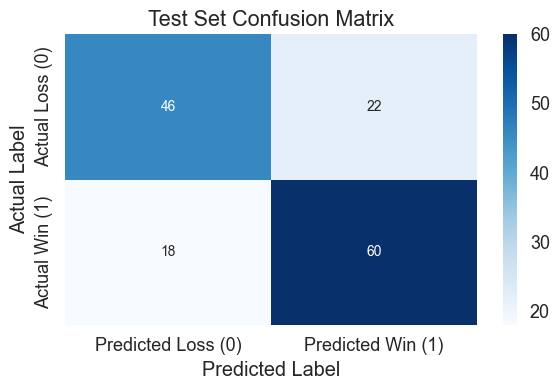


Test Set Detailed Metrics:
Sensitivity (Recall / True Positive Rate): 0.7692
Specificity (True Negative Rate): 0.6765
Precision: 0.7317
F1 Score: 0.7500

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        68
           1       0.73      0.77      0.75        78

    accuracy                           0.73       146
   macro avg       0.73      0.72      0.72       146
weighted avg       0.73      0.73      0.73       146


Test Set ROC AUC Score: 0.8005


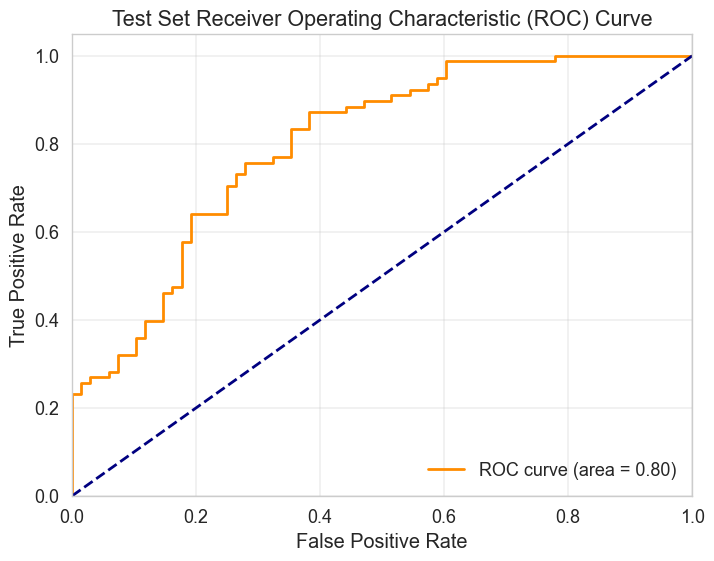

In [106]:
# Evaluate the overall best pipeline on the held-out test set

# Check if best_svm_pipeline exists and test data is valid
if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Grid search might have failed or not run.")
elif 'X_test' not in locals() or 'y_test' not in locals() or X_test.empty or y_test.empty:
     print("\nError: Test data (X_test, y_test) not available or empty. Cannot evaluate model.")
else:
    print("\nEvaluating final selected model on the test set...")
    y_pred_test = best_svm_pipeline.predict(X_test)
    y_prob_test = best_svm_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class (class 1)
    
    # --- Print Evaluation Metrics --- 
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
    
    print("\nTest Set Confusion Matrix:")
    cm_test = confusion_matrix(y_test, y_pred_test)
    # Plot confusion matrix for better visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Loss (0)', 'Predicted Win (1)'], 
                yticklabels=['Actual Loss (0)', 'Actual Win (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Test Set Confusion Matrix')
    plt.tight_layout()
    plt.savefig('svm_test_confusion_matrix.png') # Save the plot
    plt.show()
    
    # Calculate detailed metrics from confusion matrix
    tn, fp, fn, tp = cm_test.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # Same as Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print("\nTest Set Detailed Metrics:")
    print(f"Sensitivity (Recall / True Positive Rate): {sensitivity:.4f}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nTest Set Classification Report:")
    print(classification_report(y_test, y_pred_test))
    
    # --- ROC AUC Score and Curve --- 
    roc_auc_test = roc_auc_score(y_test, y_prob_test)
    print(f"\nTest Set ROC AUC Score: {roc_auc_test:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test Set Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('svm_test_roc_curve.png') # Save the plot
    plt.show()


## Feature Importance Analysis

This section analyzes which features were most influential for the best SVM model's predictions. The approach depends on the kernel type determined by the grid search:

* **Check Kernel Type:** Identify the kernel (`linear` or `rbf`) used by the `best_svm_pipeline`.
* **Linear Kernel:**
    * If the kernel is linear, extract the model coefficients (`.coef_`).
    * Create a DataFrame showing each feature and its corresponding coefficient.
    * Rank features by the absolute value of their coefficients (larger magnitude implies greater importance).
    * Plot the top 10 most important features based on absolute coefficient values.
* **Non-Linear Kernel (e.g., RBF):**
    * If the kernel is non-linear, coefficients are not directly interpretable.
    * Calculate feature importance using `permutation_importance` on the test set. This method measures the decrease in model score (F1 score, in this case) when a single feature's values are randomly shuffled.
    * Organize the mean importance scores and standard deviations into a DataFrame.
    * Plot the top 10 most important features based on mean permutation importance, including error bars representing the standard deviation across repeats.
* **Save Plot:** Save the generated feature importance plot.


Best model kernel type: rbf

Calculating feature importance using Permutation Importance (on test set)...

Feature Importance (Top 10 based on Permutation Importance):
                Feature  Importance   Std Dev
0              ypa_diff    0.021264  0.010569
1        turnovers_diff    0.004362  0.011278
2  rush_pass_ratio_diff    0.004320  0.009132
3    pass_attempts_diff    0.002823  0.006777
4   yards_per_play_diff    0.000794  0.006039
5       punt_yards_diff    0.000000  0.000000
6            sacks_diff   -0.001402  0.006589
7       pass_yards_diff   -0.001635  0.009067
8    rush_attempts_diff   -0.002046  0.012965
9    penalty_yards_diff   -0.002506  0.003431


C:\Users\User\AppData\Local\Temp\ipykernel_11708\4056323033.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10),


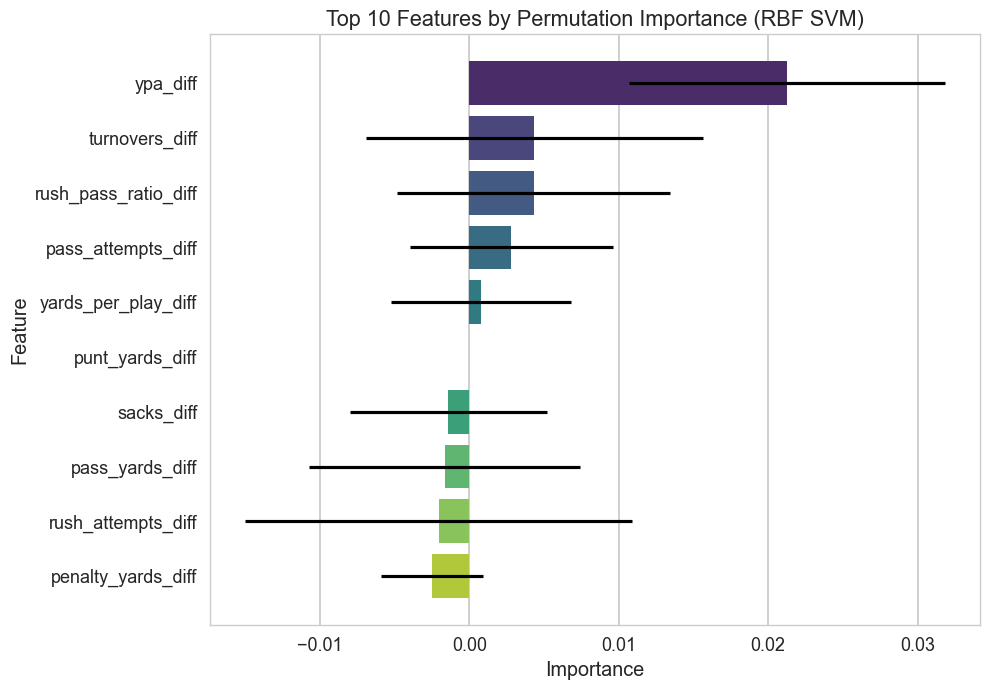

In [107]:
# --- Feature Importance --- 
# Check the kernel type of the best SVM model found by grid search

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot determine feature importance.")
else:
    best_kernel = best_svm_pipeline.named_steps['svm'].kernel
    print(f"\nBest model kernel type: {best_kernel}")

    # Get the scaler from the best pipeline to scale the full dataset for importance calculation
    # Important: Use the scaler fitted on the TRAINING data for consistency
    # Refit the best scaler on the full training set before using it here
    best_scaler_obj = best_svm_pipeline.named_steps['scaler']
    # It's generally better practice to calculate permutation importance on the test set
    # or a held-out validation set to avoid overfitting bias in importance scores.
    # We'll use the test set here.
    
    # Scale the test data using the scaler from the pipeline (already fitted on train)
    # Note: The pipeline handles scaling automatically when predicting, but for permutation 
    # importance outside the pipeline context, we might need scaled data depending on the approach.
    # However, permutation_importance can take the estimator directly.

    if best_kernel == 'linear':
        print("Calculating feature importance using Linear SVM coefficients...")
        # Coefficients are available directly for the linear kernel
        coefficients = best_svm_pipeline.named_steps['svm'].coef_[0]
        
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns, # Use columns from training data
            'Coefficient': coefficients
        })
        # Use absolute value for ranking importance magnitude
        feature_importance_df['Abs_Coefficient'] = abs(feature_importance_df['Coefficient'])
        feature_importance_df = feature_importance_df.sort_values('Abs_Coefficient', ascending=False)
        
        print("\nFeature Importance (Top 10 based on Linear SVM Coefficients):")
        print(feature_importance_df.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 7))
        sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance_df.head(10), palette='viridis')
        plt.title('Top 10 Features by Absolute Coefficient (Linear SVM)')
        plt.tight_layout()
        plt.savefig('svm_linear_feature_importance.png')
        plt.show()

    else: # For non-linear kernels like 'rbf'
        print("\nCalculating feature importance using Permutation Importance (on test set)...")
        # Use permutation importance on the test set for a less biased estimate
        perm_importance = permutation_importance(
            best_svm_pipeline, 
            X_test, 
            y_test, 
            n_repeats=10,       # Number of times to permute a feature
            random_state=42,
            scoring='f1',       # Use the same scoring metric as grid search
            n_jobs=-1
        )
        
        # Organize results into a DataFrame
        sorted_idx = perm_importance.importances_mean.argsort()[::-1] # Get indices sorted by importance
        feature_importance_df = pd.DataFrame({
            'Feature': X_test.columns[sorted_idx],
            'Importance': perm_importance.importances_mean[sorted_idx],
            'Std Dev': perm_importance.importances_std[sorted_idx]
        })
        
        print("\nFeature Importance (Top 10 based on Permutation Importance):")
        print(feature_importance_df.head(10))
        
        # Plot permutation importance
        plt.figure(figsize=(10, 7))
        ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), 
                    palette='viridis')
        # Add error bars manually
        for i, p in enumerate(ax.patches):
            ax.errorbar(p.get_width(), p.get_y() + p.get_height()/2, 
                      xerr=feature_importance_df['Std Dev'].iloc[i], 
                      fmt='none', color='black', capsize=3)
        plt.title(f'Top 10 Features by Permutation Importance ({best_kernel.upper()} SVM)')
        plt.tight_layout()
        plt.savefig(f'svm_{best_kernel}_feature_importance.png')
        plt.show()


## Cross-Validation and Baseline Comparison

This section provides further evaluation and context for the optimized SVM model. It includes:

* **Cross-Validation on Full Dataset:**
    * Performs k-fold cross-validation (using the same `StratifiedKFold` strategy as the grid search) on the *entire* dataset (`X`, `y`) using the `best_svm_pipeline`.
    * Calculates the F1 score for each fold.
    * Reports the mean and standard deviation of the cross-validation F1 scores. This gives an estimate of the model's stability and expected performance on different subsets of the data.
* **Baseline Model Comparison:**
    * Defines two baseline SVM models within pipelines: one with a linear kernel and default parameters, and one with an RBF kernel and default parameters (both using `StandardScaler`).
    * Trains these baseline models on the training set (`X_train`, `y_train`).
    * Evaluates the baselines on the test set (`X_test`, `y_test`), calculating Accuracy, F1 Score, Precision, Recall, and Training Time.
    * Combines the results of the baseline models and the previously evaluated `Optimized SVM` into a DataFrame.
    * Prints the comparison table.
    * Generates bar plots comparing the performance metrics (Accuracy, F1, Precision, Recall) and the training times of the optimized model versus the baselines.
    * Saves the comparison plots.


Performing cross-validation on the full dataset with the best pipeline...

Cross-validation F1 scores: [0.75308642 0.76433121 0.775      0.80503145 0.7483871 ]
Mean CV F1 score: 0.7692 ± 0.0202

Comparing with baseline models (untuned, default parameters)...

Training Baseline Linear SVM...
Evaluating Baseline Linear SVM on test set...

Training Baseline RBF SVM...
Evaluating Baseline RBF SVM on test set...

--- Model Comparison Table ---
                     Accuracy  F1 Score  Precision    Recall  \
Baseline Linear SVM  0.753425  0.752771   0.753258  0.753425   
Baseline RBF SVM     0.726027  0.726027   0.726027  0.726027   
Optimized SVM        0.726027  0.750000   0.731707  0.769231   

                     Training Time (s)  
Baseline Linear SVM           0.073061  
Baseline RBF SVM              0.070664  
Optimized SVM                 2.392481  


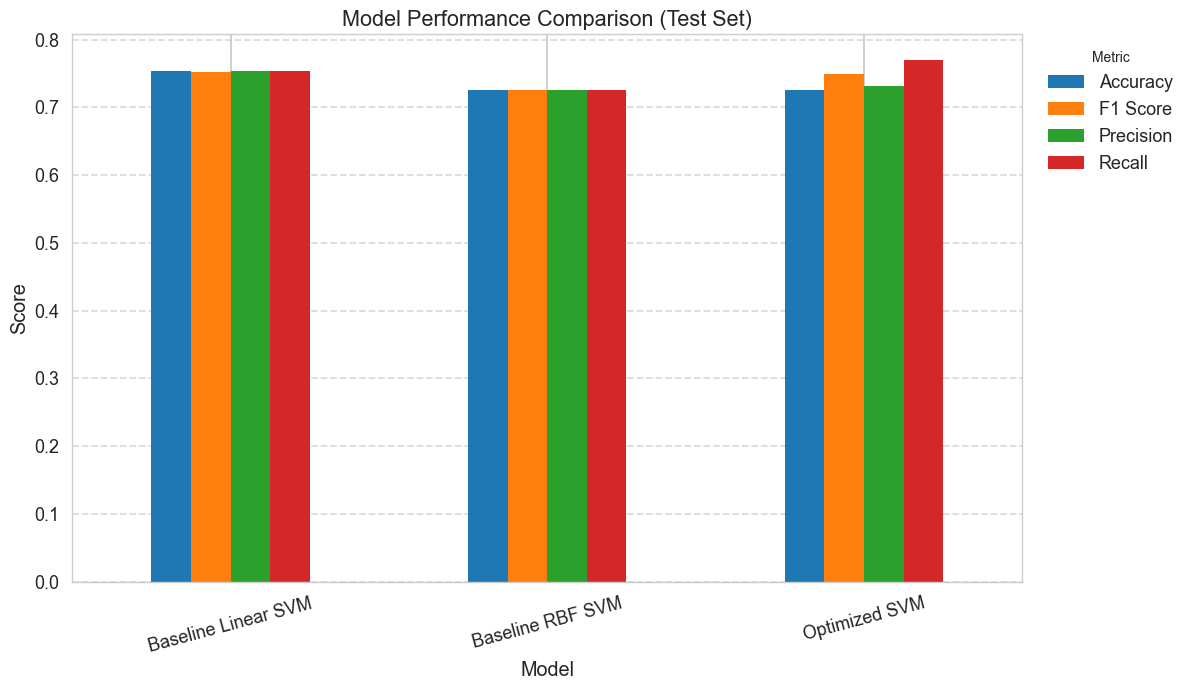

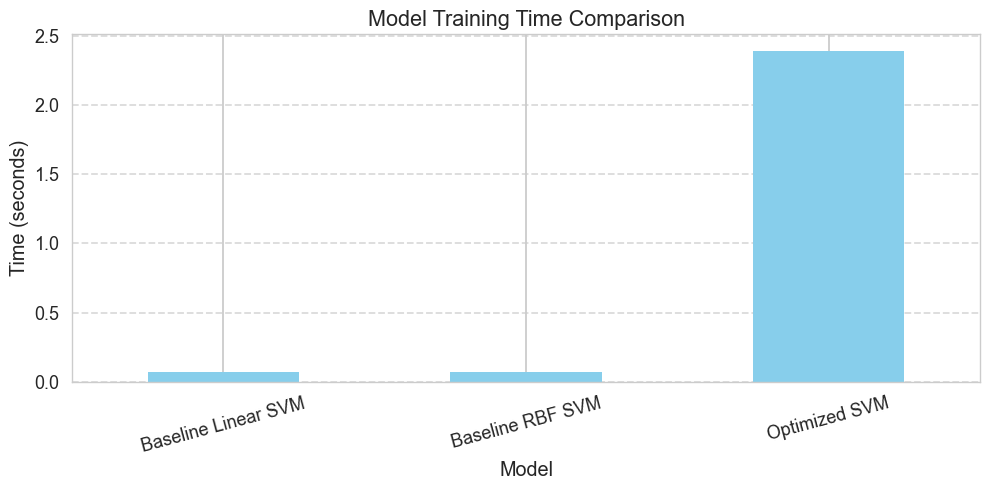

In [108]:
# --- Cross-validation for Reliability Estimation --- 
# Perform cross-validation on the *entire* dataset using the *best found pipeline*
# This gives an estimate of how the model might perform on average on new, unseen data splits

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot perform cross-validation.")
elif X.empty or y.empty:
     print("\nError: Full dataset (X, y) not available or empty. Cannot perform cross-validation.")
else:
    print("\nPerforming cross-validation on the full dataset with the best pipeline...")
    # Use the same CV strategy as in grid search
    cv_scores = cross_val_score(best_svm_pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1)
    print(f"\nCross-validation F1 scores: {cv_scores}")
    print(f"Mean CV F1 score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# --- Compare with Baseline Models --- 
print("\nComparing with baseline models (untuned, default parameters)...")

# Baseline Linear SVM (using default C=1)
baseline_linear = Pipeline([
    ('scaler', StandardScaler()), # Use standard scaler for baseline
    ('svm', SVC(kernel='linear', probability=True, random_state=42))
])

# Baseline RBF SVM (using default C=1, gamma='scale')
baseline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

# Dictionary to store results
baseline_results = {}
baseline_models = {
    'Baseline Linear SVM': baseline_linear,
    'Baseline RBF SVM': baseline_rbf
}

# Check if training data is valid
if 'X_train' not in locals() or 'y_train' not in locals() or X_train.empty or y_train.empty:
    print("\nError: Training data not available. Cannot train baseline models.")
elif 'X_test' not in locals() or 'y_test' not in locals() or X_test.empty or y_test.empty:
    print("\nError: Test data not available. Cannot evaluate baseline models.")
else:
    # Train and evaluate baseline models
    for name, model in baseline_models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        print(f"Evaluating {name} on test set...")
        y_pred_base = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_base)
        report = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
        
        baseline_results[name] = {
            'Accuracy': accuracy,
            'F1 Score': report['weighted avg']['f1-score'],
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'Training Time (s)': train_time
        }

    # Add the optimized model's results for comparison
    if 'best_svm_pipeline' in locals():
        baseline_results['Optimized SVM'] = {
            'Accuracy': test_accuracy, # Calculated in the previous evaluation cell
            'F1 Score': f1, # Calculated in the previous evaluation cell
            'Precision': precision, # Calculated in the previous evaluation cell
            'Recall': sensitivity, # Calculated in the previous evaluation cell
            'Training Time (s)': grid_search_time # Time for the winning grid search
        }
    
    # Convert results to DataFrame
    results_comparison_df = pd.DataFrame(baseline_results).T
    print("\n--- Model Comparison Table ---")
    print(results_comparison_df)
    
    # Create comparison bar chart for performance metrics
    plt.style.use('seaborn-v0_8-talk') # Use a style for better visuals
    fig, ax = plt.subplots(figsize=(12, 7))
    results_comparison_df[['Accuracy', 'F1 Score', 'Precision', 'Recall']].plot(kind='bar', ax=ax)
    ax.set_title('Model Performance Comparison (Test Set)')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=15)
    ax.legend(title='Metric', bbox_to_anchor=(1.01, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('svm_model_comparison_performance.png')
    plt.show()
    
    # Create comparison bar chart for training time
    fig, ax = plt.subplots(figsize=(10, 5))
    results_comparison_df[['Training Time (s)']].plot(kind='bar', ax=ax, legend=False, color='skyblue')
    ax.set_title('Model Training Time Comparison')
    ax.set_ylabel('Time (seconds)')
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('svm_model_comparison_time.png')
    plt.show()


## Learning Curve Analysis

Finally, this cell generates a learning curve for the best SVM pipeline. Learning curves help diagnose model performance issues related to bias and variance, and indicate whether collecting more data might be beneficial. The steps are:

* **Data Check:** Ensure the best pipeline and the full dataset (`X`, `y`) are available.
* **Generate Learning Curve Data:** Use the `learning_curve` function from scikit-learn.
    * Pass the `best_svm_pipeline`, the full dataset (`X`, `y`), and the cross-validation strategy (`cv`).
    * Specify `train_sizes` (e.g., 10 points from 10% to 100% of the training data) to evaluate performance on different dataset sizes.
    * Use F1 score for evaluation.
    * This function returns the training sizes used, and the corresponding training scores and cross-validation scores for each size across the different CV folds.
* **Calculate Statistics:** Compute the mean and standard deviation of the training and cross-validation scores across the folds for each training size.
* **Plot Learning Curve:**
    * Plot the mean training score and mean cross-validation score against the number of training examples.
    * Include shaded areas representing ± one standard deviation around the mean scores (using `fill_between`) to show variability.
    * Add title, labels, legend, and grid for clarity.
* **Save Plot:** Save the generated learning curve plot.


Generating learning curves for the best SVM pipeline...


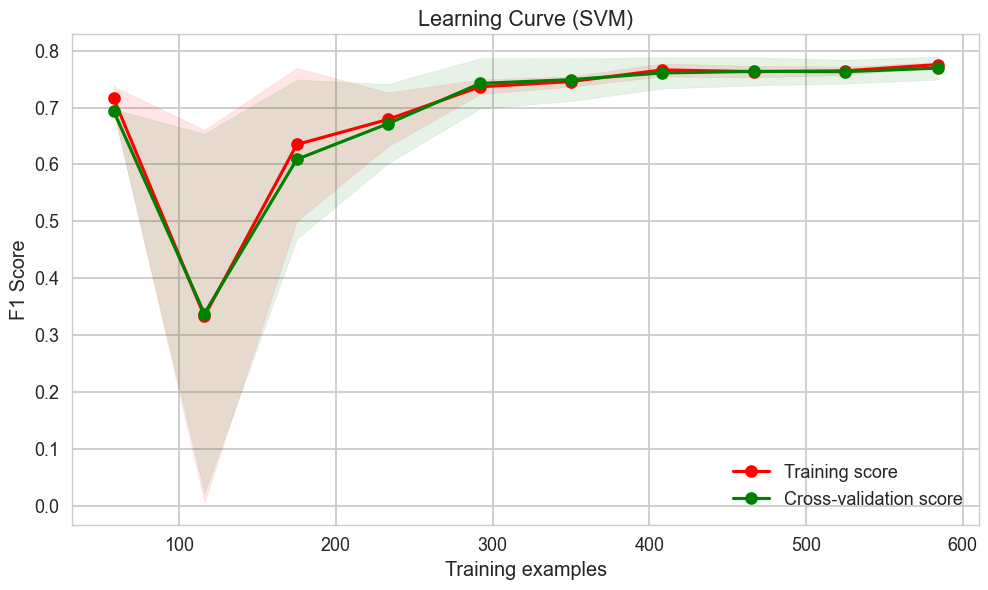


SVM analysis complete!


In [109]:
# --- Learning Curve --- 
# Generate learning curves for the best model to understand bias/variance

if 'best_svm_pipeline' not in locals():
     print("\nError: Best SVM pipeline not found. Cannot generate learning curve.")
elif X.empty or y.empty:
     print("\nError: Full dataset (X, y) not available or empty. Cannot generate learning curve.")
else:
    print("\nGenerating learning curves for the best SVM pipeline...")
    train_sizes_abs, train_scores, test_scores = learning_curve(
        best_svm_pipeline, # The best estimator pipeline found
        X,                # Full feature set
        y,                # Full target variable
        cv=cv,            # Use the same cross-validation strategy
        n_jobs=-1,        # Use all cores
        train_sizes=np.linspace(0.1, 1.0, 10), # Test 10 sizes from 10% to 100%
        scoring='f1',     # Evaluate using F1 score
        random_state=42
    )
    
    # Calculate mean and std deviation for plotting
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve (SVM)")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('svm_learning_curve.png') # Save the plot
    plt.show()
    
    print("\nSVM analysis complete!")
